In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [27]:
a = torch.randn((12, 3, 2))
a.shape

torch.Size([12, 3, 2])

In [28]:
a.flatten(1).shape

torch.Size([12, 6])

In [29]:
a[:, 0, :].shape

torch.Size([12, 2])

In [30]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [31]:
len(words)

32033

In [32]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [33]:
block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    # print(f"word is {w}")
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join([itos[i] for i in context]), itos[ix])

        context = context[1:] + [ix]

In [34]:
X = torch.tensor(X)
Y = torch.tensor(Y)

In [35]:
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [36]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        # print(f"word is {w}")
        for ch in w + '.':
          ix = stoi[ch]
          X.append(context)
          Y.append(ix)
          # print(''.join([itos[i] for i in context]), itos[ix])
          context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [37]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

In [38]:
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1: n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [39]:
emb_mat = torch.randn((27, 2))

In [40]:
emb_mat.shape

torch.Size([27, 2])

In [41]:
emb_mat[0]

tensor([ 0.4408, -1.1088])

In [42]:
emb = emb_mat[X]
emb.shape

torch.Size([228146, 3, 2])

In [43]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [44]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [45]:
h.shape

torch.Size([228146, 100])

In [46]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [47]:
Xte.shape, Yte.shape

(torch.Size([22866, 3]), torch.Size([22866]))

In [49]:
# define the model
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)

W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [50]:
sum(p.nelement() for p in parameters)

11897

In [51]:
for p in parameters:
    p.requires_grad = True

In [57]:
lre = torch.linspace(-3, 0, 1000)
lre.shape
lri = 10**lre

In [58]:
# ?torch.linspace

In [59]:
lri = []
stepi = []
lossi = []

In [69]:
ix = torch.randint(0, Xtr.shape[0], (32,))
emb = C[Xtr[ix]] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2

In [74]:
probs = logits.exp()
probs = probs / probs.sum(dim=1, keepdims=True)
loss = -probs[torch.arange(32), Ytr[ix]].log().mean()
loss

tensor(21.4283, grad_fn=<NegBackward0>)

In [75]:
loss_cross_ent = F.cross_entropy(logits, Ytr[ix])
loss_cross_ent

tensor(21.4283, grad_fn=<NllLossBackward0>)

In [63]:
import torch.nn.functional as F

In [76]:
for i in range(200_000):
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    #backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()

    # update params
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    stepi.append(i)
    lossi.append(loss.log10().item())

In [77]:
print(loss.item())

2.387498617172241


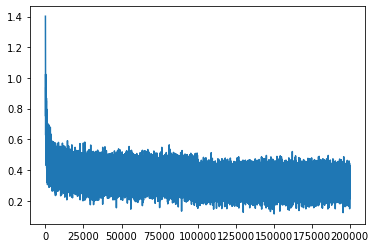

In [78]:
plt.plot(stepi, lossi)

In [79]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.127816677093506


In [80]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.1677048206329346


In [81]:
C.shape

torch.Size([27, 10])

In [82]:
C[:, 0].data

tensor([ 2.0353, -0.5275,  0.4423, -0.8043,  0.2507, -0.3350,  0.8206,  0.3325,
        -0.5700, -0.4658, -1.7695, -1.2070,  0.0993, -0.3770, -0.0587,  0.0150,
         0.3503,  1.3081,  0.3469,  0.1088,  0.1104, -0.3049,  0.2534, -0.1341,
         0.0975, -0.4817,  0.0768])

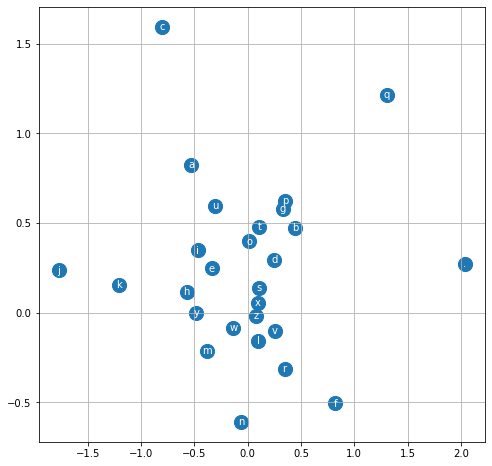

In [85]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')

plt.grid('minor')

In [88]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [87]:
C[0]

tensor([ 2.0353,  0.2733,  0.2874, -0.6125,  0.7865,  0.2214, -1.6691,  1.0185,
         0.4999,  1.0392], grad_fn=<SelectBackward0>)

In [91]:
torch.tensor([context]).shape

torch.Size([1, 3])

In [92]:
g = torch.Generator().manual_seed(2147483647 + 10)

In [94]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join([itos[i] for i in out]))

kai.
eviius.
brey.
emi.
abette.
jasti.
alpan.
benjamsya.
namarion.
ryleen.
calaira.
nak.
kamdin.
odeon.
silora.
kryner.
molly.
noan.
kaeleeode.
ryven.
